In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_test = pd.read_csv("srtt.csv")
df_baseline = pd.read_csv("../../baseline/tcp related/srtt.csv")

df_test["source"] = "TEST"
df_baseline["source"] = "BASELINE"

df_test["Time"] = pd.to_datetime(df_test["Time"])
df_baseline["Time"] = pd.to_datetime(df_baseline["Time"])

df_test["Minutes"] = (df_test["Time"] - df_test["Time"].min()).dt.total_seconds() / 60
df_baseline["Minutes"] = (df_baseline["Time"] - df_baseline["Time"].min()).dt.total_seconds() / 60

delay = 30
duration = 50

def create_cumulative_metrics(df):
    metric_columns = [col for col in df.columns if col not in ['Time', 'source', 'Minutes']]
    service_groups = {}
    for col in metric_columns:
        if '_client_' in col or '_server_' in col:
            service_name = col.split('_client_')[0] if '_client_' in col else col.split('_server_')[0]
        else:
            service_name = col
        if service_name not in service_groups:
            service_groups[service_name] = []
        service_groups[service_name].append(col)
    cumulative_df = df[['Time', 'Minutes', 'source']].copy()
    for service, columns in service_groups.items():
        cumulative_df[f'{service}_cumulative'] = df[columns].fillna(0).sum(axis=1)
    return cumulative_df

df_test_cumulative = create_cumulative_metrics(df_test)
df_baseline_cumulative = create_cumulative_metrics(df_baseline)

cumulative_metrics = [col for col in df_test_cumulative.columns if col.endswith('_cumulative')]
key_cumulative_metrics = cumulative_metrics[:5]

print(f"Available cumulative metrics: {cumulative_metrics}")
print(f"Selected metrics for plotting: {key_cumulative_metrics}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cumulative SRTT Metrics Comparison: Baseline vs Test', fontsize=16, fontweight='bold')
axes_flat = axes.flatten()

for i, metric in enumerate(key_cumulative_metrics):
    if i < len(axes_flat):
        ax = axes_flat[i]
        ax.plot(df_test_cumulative["Minutes"], df_test_cumulative[metric], label="TEST", color='red', linewidth=2, alpha=0.8)
        ax.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative[metric], label="BASELINE", color='blue', linewidth=2, alpha=0.8)
        ax.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
        service_name = metric.replace('_cumulative', '').replace('_', ' ').title()
        ax.set_title(f'{service_name} (Cumulative)', fontsize=12, fontweight='bold')
        ax.set_xlabel("Minutes since start", fontsize=10)
        ax.set_ylabel("Cumulative SRTT Value", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='upper right', fontsize=9)

for i in range(len(key_cumulative_metrics), len(axes_flat)):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

if key_cumulative_metrics:
    metric_focus = key_cumulative_metrics[0]
    plt.plot(df_test_cumulative["Minutes"], df_test_cumulative[metric_focus], label="TEST", color='red', linewidth=2.5)
    plt.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative[metric_focus], label="BASELINE", color='blue', linewidth=2.5)
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
    service_name = metric_focus.replace('_cumulative', '').replace('_', ' ').title()
    plt.title(f"Cumulative SRTT Comparison: {service_name}", fontsize=16)
    plt.xlabel("Minutes since start", fontsize=12)
    plt.ylabel("Cumulative SRTT Value", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

print("=== Cumulative SRTT Statistical Summary ===")
for metric in key_cumulative_metrics:
    service_name = metric.replace('_cumulative', '')
    print(f"\nService: {service_name}")
    print(f"TEST Dataset - Mean: {df_test_cumulative[metric].mean():.2f}, Std: {df_test_cumulative[metric].std():.2f}")
    print(f"BASELINE Dataset - Mean: {df_baseline_cumulative[metric].mean():.2f}, Std: {df_baseline_cumulative[metric].std():.2f}")
    test_period_test = df_test_cumulative[(df_test_cumulative["Minutes"] >= delay) & (df_test_cumulative["Minutes"] <= delay + duration)]
    test_period_baseline = df_baseline_cumulative[(df_baseline_cumulative["Minutes"] >= delay) & (df_baseline_cumulative["Minutes"] <= delay + duration)]
    if not test_period_test.empty and not test_period_baseline.empty:
        test_mean = test_period_test[metric].mean()
        baseline_mean = test_period_baseline[metric].mean()
        difference = test_mean - baseline_mean
        percentage_change = (difference / baseline_mean * 100) if baseline_mean != 0 else 0
        print(f"During Test Period ({delay}-{delay+duration} minutes):")
        print(f"TEST Dataset - Mean: {test_mean:.2f}")
        print(f"BASELINE Dataset - Mean: {baseline_mean:.2f}")
        print(f"Difference: {difference:.2f} ({percentage_change:.1f}% change)")

df_test_cumulative['total_system_srtt'] = df_test_cumulative[cumulative_metrics].sum(axis=1)
df_baseline_cumulative['total_system_srtt'] = df_baseline_cumulative[cumulative_metrics].sum(axis=1)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
plt.plot(df_test_cumulative["Minutes"], df_test_cumulative['total_system_srtt'], label="TEST (Total System)", color='red', linewidth=2.5)
plt.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative['total_system_srtt'], label="BASELINE (Total System)", color='blue', linewidth=2.5)
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
plt.title("Total System SRTT Comparison (All Services Combined)", fontsize=16)
plt.xlabel("Minutes since start", fontsize=12)
plt.ylabel("Total System SRTT Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()


=== Creating cumulative metrics for TEST dataset ===
TEST cumulative data shape: (487, 20)

=== Creating cumulative metrics for BASELINE dataset ===
BASELINE cumulative data shape: (486, 20)

TEST data time range: 2025-05-17 23:59:45 to 2025-05-18 02:01:15
BASELINE data time range: 1970-01-01 00:00:00 to 1970-01-01 00:00:00

TEST cumulative metrics: ['localhost_cumulative', 'api_gateway_cumulative', 'config_cumulative', 'discovery_cumulative', 'vets_service_cumulative', 'discovery_server_cumulative', 'customers_service_cumulative', 'customers_cumulative', 'visits_cumulative', 'vets_cumulative', 'genai_cumulative', 'customers_server_cumulative', 'visits_server_cumulative', 'vets_server_cumulative', 'admin_cumulative', 'admin_client_cumulative', 'discovery_server.1_cumulative']
BASELINE cumulative metrics: ['localhost_cumulative', 'api_gateway_cumulative', 'config_cumulative', 'discovery_cumulative', 'vets_service_cumulative', 'discovery_server_cumulative', 'customers_service_cumulative'

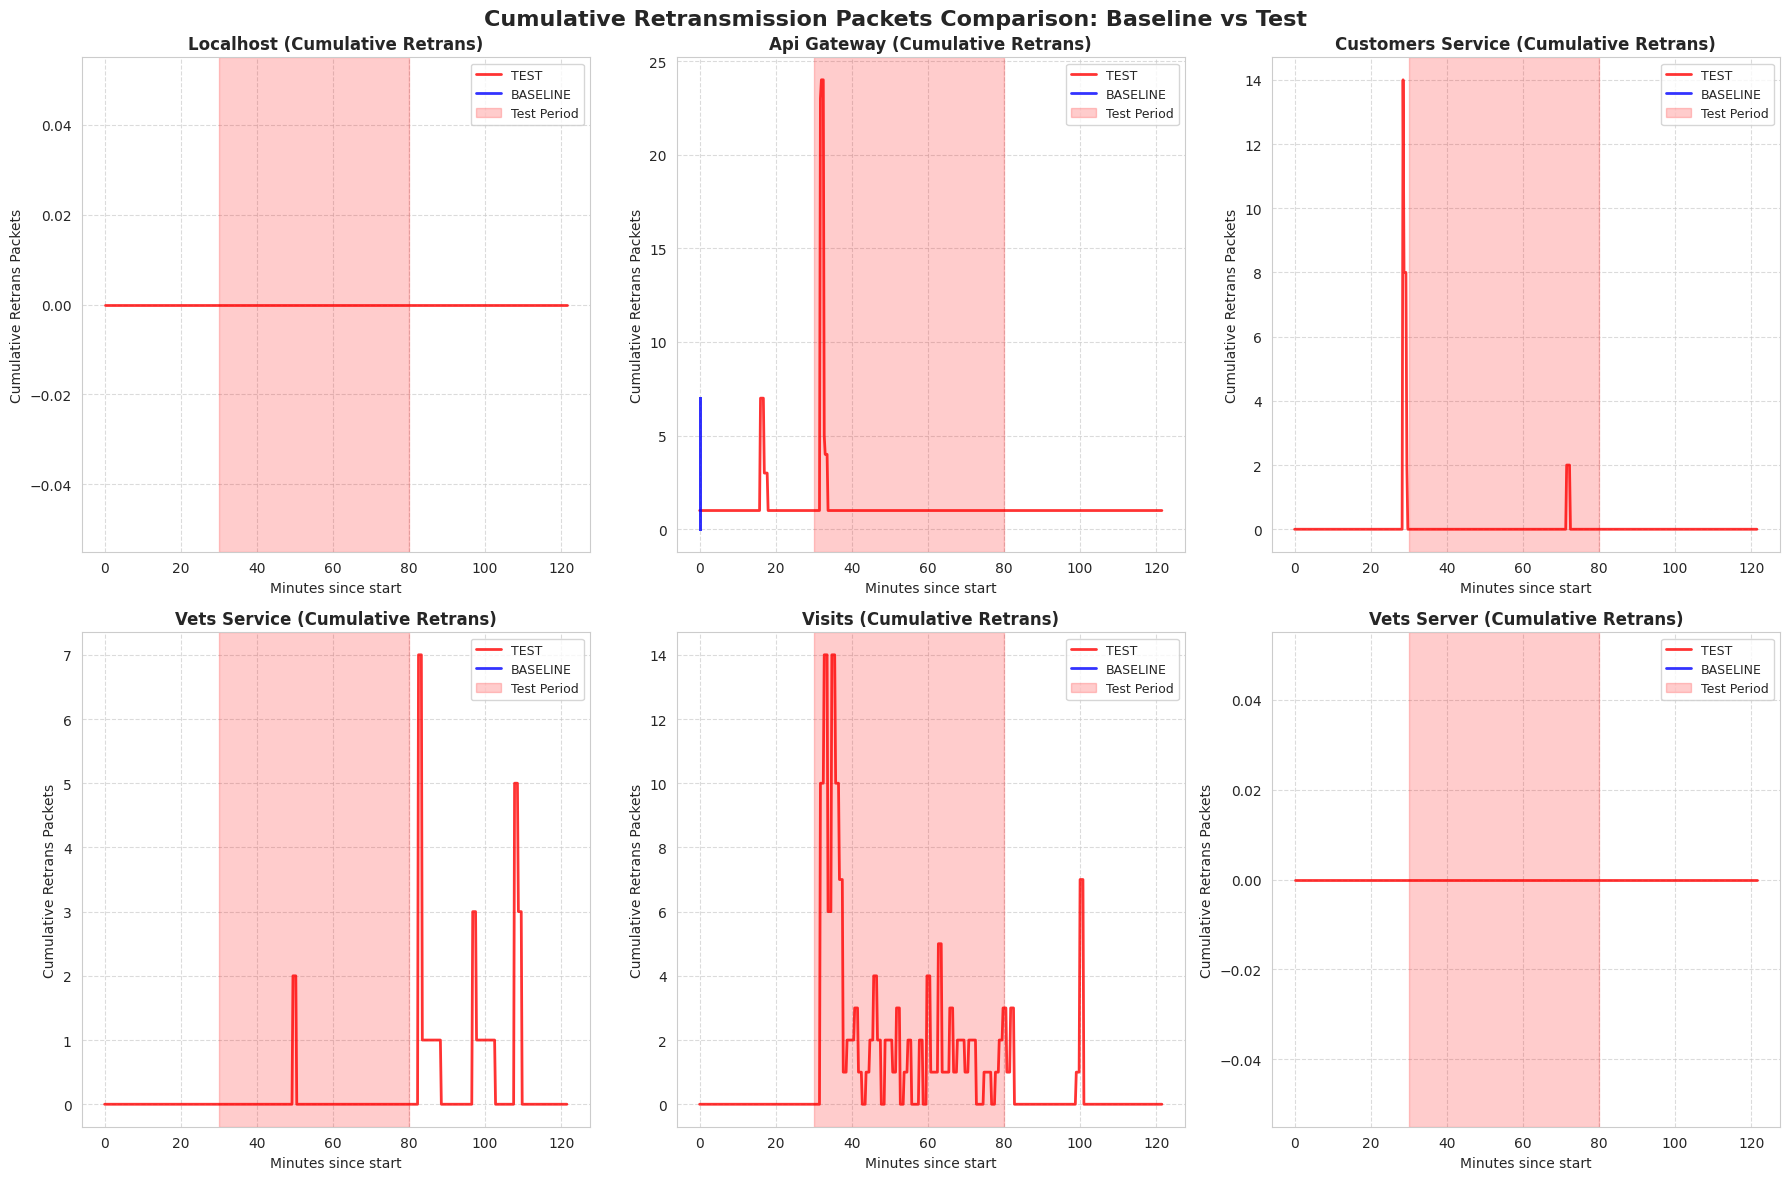

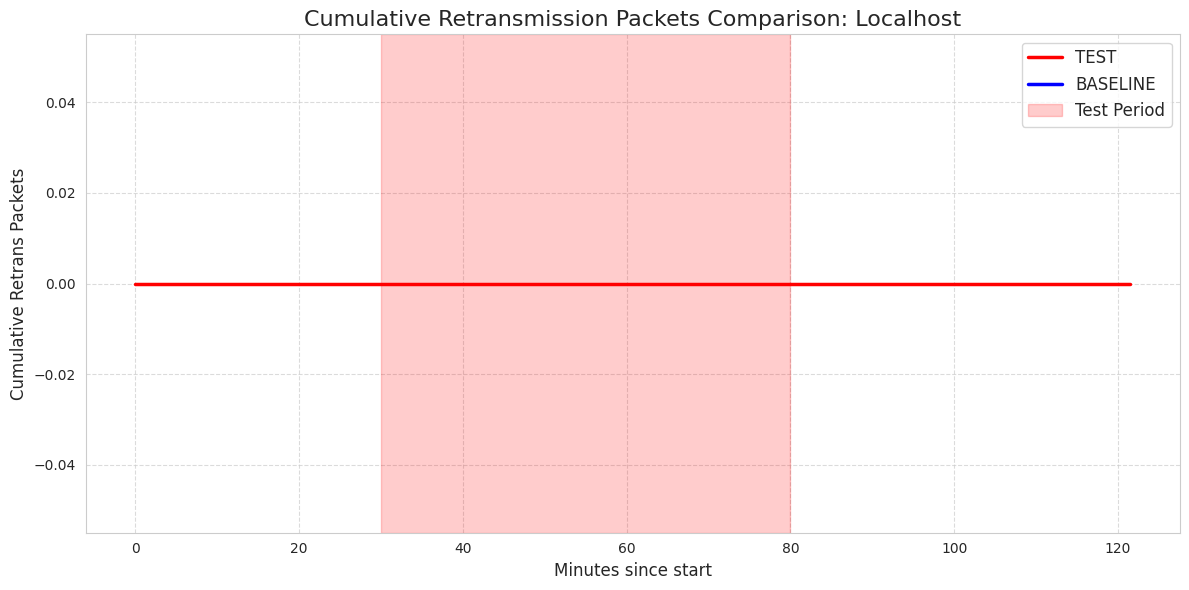

=== Cumulative Retransmission Packets Statistical Summary ===

Service: localhost
TEST Dataset - Mean: 0.00, Std: 0.00
BASELINE Dataset - Mean: 0.00, Std: 0.00

Service: api_gateway
TEST Dataset - Mean: 1.28, Std: 2.14
BASELINE Dataset - Mean: 0.48, Std: 1.47

Service: customers_service
TEST Dataset - Mean: 0.10, Std: 0.91
BASELINE Dataset - Mean: 0.00, Std: 0.00

Service: vets_service
TEST Dataset - Mean: 0.25, Std: 0.90
BASELINE Dataset - Mean: 0.00, Std: 0.00

Service: visits
TEST Dataset - Mean: 1.13, Std: 2.47
BASELINE Dataset - Mean: 0.00, Std: 0.00

Service: vets_server
TEST Dataset - Mean: 0.00, Std: 0.00
BASELINE Dataset - Mean: 0.00, Std: 0.00


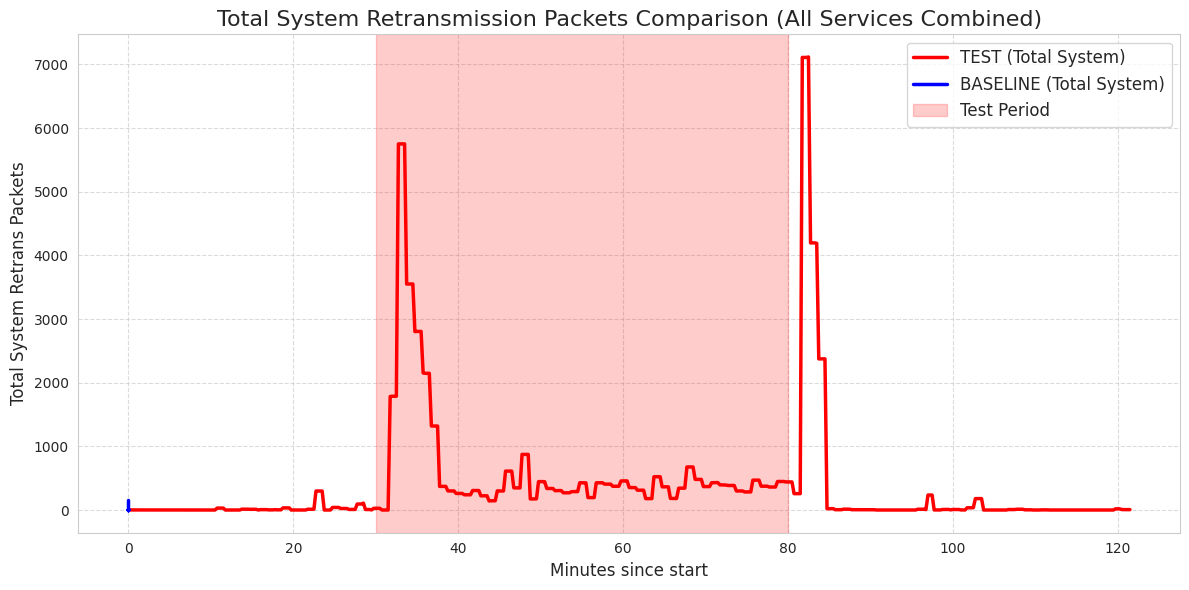


=== Peak Retransmission Analysis ===
TEST Dataset - Peak retrans: 7117 packets at 82.5 minutes
BASELINE Dataset - Peak retrans: 232 packets at nan minutes
Peak difference: 6885 packets (2967.7% change)


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import re

# Load the retransmission data
df_test = pd.read_csv("retrans_packets.csv")  # Replace with your test retrans file path
df_baseline = pd.read_csv("../../baseline/tcp related/retrans_packets.csv")
  # Replace with your baseline retrans file path

# Function to replace NaN with mode for each column
def replace_nan_with_mode(df):
    df_clean = df.copy()
    for col in df_clean.columns:
        if col != 'Time':  # Skip the Time column
            # Calculate mode for the column
            mode_values = df_clean[col].mode()
            if len(mode_values) > 0:
                mode_value = mode_values[0]
            else:
                mode_value = 0  # If no mode found, use 0
            
            # Replace NaN with mode
            df_clean[col] = df_clean[col].fillna(mode_value)
    return df_clean

# Replace NaN values with mode for each dataset
df_test = replace_nan_with_mode(df_test)
df_baseline = replace_nan_with_mode(df_baseline)

# Add source labels
df_test["source"] = "TEST"
df_baseline["source"] = "BASELINE"

# Convert Time to datetime
df_test["Time"] = pd.to_datetime(df_test["Time"])
df_baseline["Time"] = pd.to_datetime(df_baseline["Time"])

# Calculate minutes since start
df_test["Minutes"] = (df_test["Time"] - df_test["Time"].min()).dt.total_seconds() / 60
df_baseline["Minutes"] = (df_baseline["Time"] - df_baseline["Time"].min()).dt.total_seconds() / 60

# Define test period parameters
delay = 30
duration = 50

def create_cumulative_metrics(df):
    """Create cumulative metrics by grouping related columns"""
    metric_columns = [col for col in df.columns if col not in ['Time', 'source', 'Minutes']]
    service_groups = {}

    for col in metric_columns:
        if '_client_' in col or '_server_' in col:
            service_name = col.split('_client_')[0] if '_client_' in col else col.split('_server_')[0]
        elif col.endswith('_client') or col.endswith('_server'):
            service_name = col.replace('_client', '').replace('_server', '')
        elif any(digit in col for digit in '23456789'):  # servizi numerati
            service_name = re.sub(r'\d+', '', col)
        else:
            service_name = col

        if service_name not in service_groups:
            service_groups[service_name] = []
        service_groups[service_name].append(col)

    # Crea nuovo DataFrame cumulativo
    cumulative_df = df[['Time', 'Minutes', 'source']].copy()

    for service, columns in service_groups.items():
        numeric_data = df[columns].select_dtypes(include=['number']).fillna(0)
        if not numeric_data.empty:
            cumulative_df[f'{service}_cumulative'] = numeric_data.sum(axis=1)
        else:
            cumulative_df[f'{service}_cumulative'] = 0

    return cumulative_df


# Create cumulative metrics
print("=== Creating cumulative metrics for TEST dataset ===")
df_test_cumulative = create_cumulative_metrics(df_test)
print(f"TEST cumulative data shape: {df_test_cumulative.shape}")

print("\n=== Creating cumulative metrics for BASELINE dataset ===")
df_baseline_cumulative = create_cumulative_metrics(df_baseline)
print(f"BASELINE cumulative data shape: {df_baseline_cumulative.shape}")

# Check if both datasets have data
print(f"\nTEST data time range: {df_test_cumulative['Time'].min()} to {df_test_cumulative['Time'].max()}")
print(f"BASELINE data time range: {df_baseline_cumulative['Time'].min()} to {df_baseline_cumulative['Time'].max()}")

# Get cumulative metrics columns
cumulative_metrics = [col for col in df_test_cumulative.columns if col.endswith('_cumulative')]
baseline_cumulative_metrics = [col for col in df_baseline_cumulative.columns if col.endswith('_cumulative')]

print(f"\nTEST cumulative metrics: {cumulative_metrics}")
print(f"BASELINE cumulative metrics: {baseline_cumulative_metrics}")

# Ensure both datasets have the same metrics
common_metrics = list(set(cumulative_metrics) & set(baseline_cumulative_metrics))
print(f"Common metrics between TEST and BASELINE: {common_metrics}")

if not common_metrics:
    print("WARNING: No common metrics found between TEST and BASELINE datasets!")
    print("This might cause plotting issues.")
    
cumulative_metrics = common_metrics if common_metrics else cumulative_metrics

# Select key services including localhost, api_gateway, customers_service, vets_service, and others
key_services = [
    'localhost_cumulative',
    'api_gateway_cumulative', 
    'customers_service_cumulative',
    'vets_service_cumulative',
    'visits_service_cumulative',
    'genai_service_cumulative'
]

# Filter to only include metrics that exist in the data
key_cumulative_metrics = [metric for metric in key_services if metric in cumulative_metrics]

# If some key services aren't found, add other available ones to reach 6 total
if len(key_cumulative_metrics) < 6:
    remaining_metrics = [m for m in cumulative_metrics if m not in key_cumulative_metrics]
    key_cumulative_metrics.extend(remaining_metrics[:6-len(key_cumulative_metrics)])

print(f"Available cumulative metrics: {cumulative_metrics}")
print(f"Selected metrics for plotting: {key_cumulative_metrics}")

# Create subplot visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Cumulative Retransmission Packets Comparison: Baseline vs Test', fontsize=16, fontweight='bold')
axes_flat = axes.flatten()

for i, metric in enumerate(key_cumulative_metrics):
    if i < len(axes_flat):
        ax = axes_flat[i]
        
        # Check if metric exists in both datasets
        if metric not in df_test_cumulative.columns:
            print(f"Warning: {metric} not found in TEST dataset")
            continue
        if metric not in df_baseline_cumulative.columns:
            print(f"Warning: {metric} not found in BASELINE dataset")
            continue
        
        # Plot lines with error handling
        try:
            ax.plot(df_test_cumulative["Minutes"], df_test_cumulative[metric], 
                    label="TEST", color='red', linewidth=2, alpha=0.8)
            ax.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative[metric], 
                    label="BASELINE", color='blue', linewidth=2, alpha=0.8)
        except Exception as e:
            print(f"Error plotting {metric}: {e}")
            continue
        
        # Add test period shading
        ax.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
        
        # Format title and labels
        service_name = metric.replace('_cumulative', '').replace('_', ' ').title()
        ax.set_title(f'{service_name} (Cumulative Retrans)', fontsize=12, fontweight='bold')
        ax.set_xlabel("Minutes since start", fontsize=10)
        ax.set_ylabel("Cumulative Retrans Packets", fontsize=10)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='upper right', fontsize=9)

# Remove unused subplots
for i in range(len(key_cumulative_metrics), len(axes_flat)):
    fig.delaxes(axes_flat[i])

plt.tight_layout()
plt.show()

# Create focused plot for the first metric
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

if key_cumulative_metrics:
    metric_focus = key_cumulative_metrics[0]
    
    plt.plot(df_test_cumulative["Minutes"], df_test_cumulative[metric_focus], 
             label="TEST", color='red', linewidth=2.5)
    plt.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative[metric_focus], 
             label="BASELINE", color='blue', linewidth=2.5)
    
    # Add test period shading
    plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")
    
    # Format plot
    service_name = metric_focus.replace('_cumulative', '').replace('_', ' ').title()
    plt.title(f"Cumulative Retransmission Packets Comparison: {service_name}", fontsize=16)
    plt.xlabel("Minutes since start", fontsize=12)
    plt.ylabel("Cumulative Retrans Packets", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(loc='upper right', fontsize=12)
    plt.tight_layout()
    plt.show()

# Statistical analysis
print("=== Cumulative Retransmission Packets Statistical Summary ===")
for metric in key_cumulative_metrics:
    service_name = metric.replace('_cumulative', '')
    print(f"\nService: {service_name}")
    
    # Overall statistics
    print(f"TEST Dataset - Mean: {df_test_cumulative[metric].mean():.2f}, Std: {df_test_cumulative[metric].std():.2f}")
    print(f"BASELINE Dataset - Mean: {df_baseline_cumulative[metric].mean():.2f}, Std: {df_baseline_cumulative[metric].std():.2f}")
    
    # Test period analysis
    test_period_test = df_test_cumulative[
        (df_test_cumulative["Minutes"] >= delay) & 
        (df_test_cumulative["Minutes"] <= delay + duration)
    ]
    test_period_baseline = df_baseline_cumulative[
        (df_baseline_cumulative["Minutes"] >= delay) & 
        (df_baseline_cumulative["Minutes"] <= delay + duration)
    ]
    
    if not test_period_test.empty and not test_period_baseline.empty:
        test_mean = test_period_test[metric].mean()
        baseline_mean = test_period_baseline[metric].mean()
        difference = test_mean - baseline_mean
        percentage_change = (difference / baseline_mean * 100) if baseline_mean != 0 else 0
        
        print(f"During Test Period ({delay}-{delay+duration} minutes):")
        print(f"TEST Dataset - Mean: {test_mean:.2f}")
        print(f"BASELINE Dataset - Mean: {baseline_mean:.2f}")
        print(f"Difference: {difference:.2f} ({percentage_change:.1f}% change)")

# Total system retransmission analysis
df_test_cumulative['total_system_retrans'] = df_test_cumulative[cumulative_metrics].sum(axis=1)
df_baseline_cumulative['total_system_retrans'] = df_baseline_cumulative[cumulative_metrics].sum(axis=1)

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

plt.plot(df_test_cumulative["Minutes"], df_test_cumulative['total_system_retrans'], 
         label="TEST (Total System)", color='red', linewidth=2.5)
plt.plot(df_baseline_cumulative["Minutes"], df_baseline_cumulative['total_system_retrans'], 
         label="BASELINE (Total System)", color='blue', linewidth=2.5)

# Add test period shading
plt.axvspan(delay, delay + duration, color='red', alpha=0.2, label="Test Period")

plt.title("Total System Retransmission Packets Comparison (All Services Combined)", fontsize=16)
plt.xlabel("Minutes since start", fontsize=12)
plt.ylabel("Total System Retrans Packets", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

# Additional analysis: Peak retransmission periods
print("\n=== Peak Retransmission Analysis ===")
test_max = df_test_cumulative['total_system_retrans'].max()
baseline_max = df_baseline_cumulative['total_system_retrans'].max()

test_max_time = df_test_cumulative.loc[df_test_cumulative['total_system_retrans'].idxmax(), 'Minutes']
baseline_max_time = df_baseline_cumulative.loc[df_baseline_cumulative['total_system_retrans'].idxmax(), 'Minutes']

print(f"TEST Dataset - Peak retrans: {test_max:.0f} packets at {test_max_time:.1f} minutes")
print(f"BASELINE Dataset - Peak retrans: {baseline_max:.0f} packets at {baseline_max_time:.1f} minutes")
print(f"Peak difference: {test_max - baseline_max:.0f} packets ({((test_max - baseline_max)/baseline_max*100):.1f}% change)")
